# Example 1.E: Heavy Sampling of Edges
### Sam Reynolds, 2024

This example revisits the computations in [Example 1.A](ex1a-square-hole.ipynb), but this time we are interested in changing the number of sampled points on each edge of the mesh cell. In particular, we will demonstrate that heavy sampling is computationally feasible when combined with trigonometric interpolation.

As usual, we begin with importing the necessary packages.

In [85]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
from time import time

## Using Interpolation to Boost Performance

The most important change we will make is in the following line. 
The `interp` parameter of the `get_quad_dict()` function will define two parallel quadrature schemes:
1. the standard one that samples $2n+1$ points per edge, and
2. a "reduced" version that samples $2m+1$ points per edge, with $m = n / k$, where $k=$`interp`. Obviously, **we need $k$ to be a divisor of $n$**. Furthermore, we require that $m \geq 4$. 

In [86]:
# define quadrature schemes
interp = 8
quad_dict = pf.get_quad_dict(n=4*interp, interp=interp)

## Set Up the Problem

### Define a Mesh Cell

We then proceed as usual; next we define the mesh cell $K$.

In [87]:
# define vertices
verts: list[pf.Vert] = []
verts.append(pf.Vert(x=0.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=1.0))
verts.append(pf.Vert(x=0.0, y=1.0))
verts.append(pf.Vert(x=0.5, y=0.5))  # center of circle

# define edges
edges: list[pf.Edge] = []
edges.append(pf.Edge(verts[0], verts[1], pos_cell_idx=0))
edges.append(pf.Edge(verts[1], verts[2], pos_cell_idx=0))
edges.append(pf.Edge(verts[2], verts[3], pos_cell_idx=0))
edges.append(pf.Edge(verts[3], verts[0], pos_cell_idx=0))
edges.append(
    pf.Edge(
        verts[4],
        verts[4],
        neg_cell_idx=0,
        curve_type="circle",
        quad_type="trap",
        radius=0.25,
    )
)

# define mesh cell
K = pf.MeshCell(idx=0, edges=edges)

# parameterize edges
K.parameterize(quad_dict)

### Define the Nyström solver

The Nyström solver will use the reduced-sampled version of $K$ to set up the linear systems for obtaining the harmonic conjugate and anti-Laplacian. 

In [88]:
nyst = pf.NystromSolver(K)

### Define Local Functions

As in [Example 1.A](ex1a-square-hole.ipynb), we define the local function $v$ as
\begin{align*}
	v(x) = e^{x_1} \, \cos x_2 + a \ln|x-\xi| + x_1^3 x_2 + x_1 x_2^3
	~,
\end{align*}
where $a = 1$ and $\xi = (0.5, 0.5)$,

In [89]:
# set target value of logarithmic coefficient
a_exact = 1.0

# set point in hole interior
xi = [0.5, 0.5]

# get the coordinates of sampled boundary points
x1, x2 = K.get_boundary_points()

# define trace of v
v_trace = (
    np.exp(x1) * np.cos(x2)
    + 0.5 * a_exact * np.log((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2)
    + x1**3 * x2
    + x1 * x2**3
)

# create Polynomial object
v_laplacian = pf.Polynomial([[12.0, 1, 1]])

# create local function object
v = pf.LocalFunction(nyst=nyst, lap_poly=v_laplacian, has_poly_trace=False)
v.set_trace_values(v_trace)

The local function $w$ is given by
\begin{align*}
	w(x) = \frac{x_1 - 0.5}{(x_1 - 0.5)^2 + (y - 0.5)^2} + x_1^3 + x_1 x_2^2
	~.
\end{align*}
Again, we have that $w = \psi + Q$ is the sum of a harmonic function and 
a polynomial, with
\begin{align*}
	\psi(x) = \frac{x_1 - 0.5}{(x_1 - 0.5)^2 + (y - 0.5)^2} 
	~,
	\quad
	Q(x) = x_1^3 + x_1 x_2^2
	~.
\end{align*}

In [90]:
# trace of w
w_trace = (
    (x1 - 0.5) / ((x1 - 0.5) ** 2 + (x2 - 0.5) ** 2) + x1**3 + x1 * x2**2
)

# define a monomial term by specifying its multi-index and coefficient
w_laplacian = pf.Polynomial([[8.0, 1, 0]])

# declare w as local function object
w = pf.LocalFunction(nyst, lap_poly=w_laplacian, has_poly_trace=False)
w.set_trace_values(w_trace)

We then compute all of the function metadata, such as the harmonic conjugate, normal derivative, anit-Laplacian, etc.

**Suggestion:** Try changing the `interp` parameter above, and note the difference in computation time.

In [91]:
ti = time()
v.compute_all()
w.compute_all()
tf = time()
print(f"{tf-ti:.2e}")

3.38e-02


## Errors in Intermediate Quantities

### Error in Logarithmic Coefficient

In [92]:
print("Computed logarithmic coefficient = ", v.log_coef[0])
print(f"Error = {abs(v.log_coef[0] - a_exact):.2e}")

Computed logarithmic coefficient =  1.0017044962332027
Error = 1.70e-03


### Error in Harmonic Conjugate Trace  

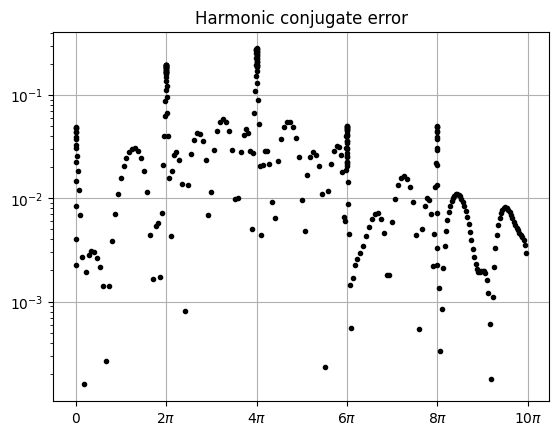

Max pointwise error = 2.8106e-01
L^2 norm of error = 6.1581e-02


In [93]:
# get computed value of psi_hat
psi_hat_computed = v.get_harmonic_conjugate()

# get exact trace of psi_hat
psi_hat_exact = np.exp(x1) * np.sin(x2)

# average square distance between values
boundary_length = K.integrate_over_boundary(np.ones((K.num_pts,)))
integrated_difference = K.integrate_over_boundary(
    psi_hat_exact - psi_hat_computed
)
c = -integrated_difference / boundary_length

# compute errors in harmonic conjugate
psi_hat_error = np.abs(psi_hat_exact - psi_hat_computed + c)

# plot harmonic conjugate pointwise errors
pf.plot.TracePlot(
    traces=psi_hat_error,
    fmt="k.",
    title="Harmonic conjugate error",
    K=K,
    quad_dict=quad_dict,
    log_scale=True,
).draw()

# compute L^2(\partial K) error
max_hc_error = max(psi_hat_error)
l2_hc_error = np.sqrt(K.integrate_over_boundary(psi_hat_error**2))
print("Max pointwise error = %.4e" % max_hc_error)
print("L^2 norm of error = %.4e" % l2_hc_error)

### Error in the Weighted Normal Derivative

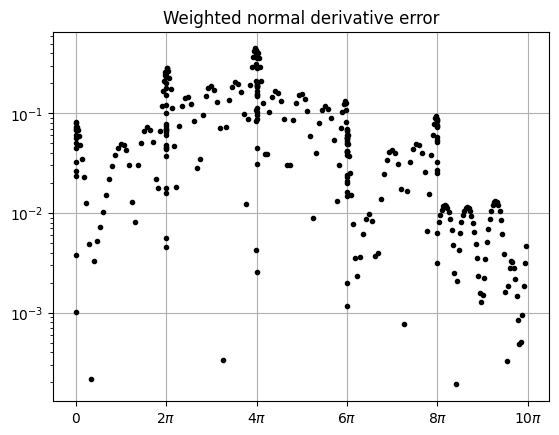

Max pointwise error = 4.4688e-01
L^2 norm of wnd error = 2.1547e-01


In [94]:
# define the components of the gradient of phi
phi_x1 = np.exp(x1) * np.cos(x2) + a_exact * (x1 - xi[0]) / (
    (x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2
)
phi_x2 = -np.exp(x1) * np.sin(x2) + a_exact * (x2 - xi[1]) / (
    (x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2
)

# compute exact weighted normal derivative
phi_nd = K.dot_with_normal(phi_x1, phi_x2)
phi_wnd_exact = K.multiply_by_dx_norm(phi_nd)

# get computed values
phi_wnd_computed = v.get_harmonic_weighted_normal_derivative()

# compute errors
wnd_error = np.abs(phi_wnd_computed - phi_wnd_exact)

# plot weighted normal derivative pointwise errors
pf.plot.TracePlot(
    traces=wnd_error,
    fmt="k.",
    title="Weighted normal derivative error",
    K=K,
    quad_dict=quad_dict,
    log_scale=True,
).draw()

# compute and print errors
max_wnd_error = max(wnd_error)
l2_wnd_error = np.sqrt(K.integrate_over_boundary(wnd_error**2))
print("Max pointwise error = %.4e" % max_wnd_error)
print("L^2 norm of wnd error = %.4e" % l2_wnd_error)

### Anti-Laplacian Errors

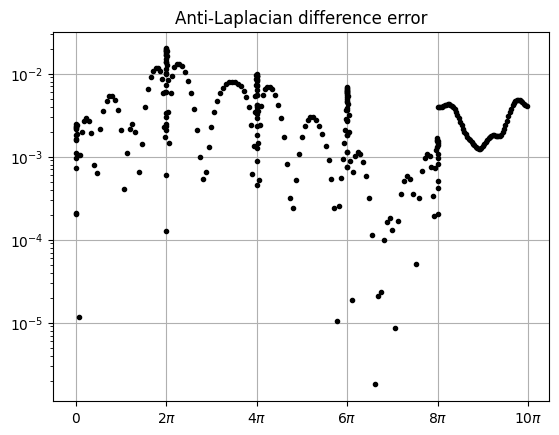

Max pointwise error = 2.0077e-02
L^2 norm of error = 1.0166e-02


In [95]:
# an exact anti-Laplacian
PHI_exact = 0.25 * np.exp(x1) * (
    x1 * np.cos(x2) + x2 * np.sin(x2)
) + a_exact * 0.25 * ((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2) * (
    0.5 * np.log((x1 - xi[0]) ** 2 + (x2 - xi[1]) ** 2) - 1
)

# computed anti-Laplacian
PHI_computed = v.get_anti_laplacian_harmonic_part()

# compute difference between expected and computed
PHI_diff = PHI_exact - PHI_computed

# correct with least squares linear regression
X = np.zeros((K.num_pts, 2))
X[:, 0] = x1
X[:, 1] = x2
XX = np.transpose(X) @ X
Xy = np.transpose(X) @ PHI_diff
aa = np.linalg.solve(XX, Xy)
PHI_diff_fit = X @ aa

# compute errors
PHI_diff_error = np.abs(PHI_diff_fit - PHI_diff)

# plot anti-Laplacian pointwise errors
pf.plot.TracePlot(
    traces=PHI_diff_error,
    fmt="k.",
    title="Anti-Laplacian difference error",
    K=K,
    quad_dict=quad_dict,
    log_scale=True,
).draw()

# compute and print error
max_PHI_error = max(PHI_diff_error)
l2_PHI_error = np.sqrt(K.integrate_over_boundary(PHI_diff_error**2))
print("Max pointwise error = %.4e" % max_PHI_error)
print("L^2 norm of error = %.4e" % l2_PHI_error)

### $H^1$ Semi-inner Product Error

In [96]:
h1_vw_computed = v.get_h1_semi_inner_prod(w)
h1_vw_exact = 4.46481780319135
print("H^1 error (vw) = ", abs(h1_vw_computed - h1_vw_exact))

H^1 error (vw) =  0.012081279877119044


### $L^2$ Inner Product Error

In [97]:
l2_vw_computed = v.get_l2_inner_prod(w)
l2_vw_exact = 1.39484950156676
print("L^2 error (vw) = ", abs(l2_vw_computed - l2_vw_exact))

L^2 error (vw) =  0.0033170663933517197


## Convergence Studies



| n | k | n/k | a_1 error | hc error |	wnd error |	al error | H1 error | L2 error | time |
|--|--|--|--|--|--|--|--|--|--|
|
| 4  | 1  | 4 |  
| 8  | 2  | 4 |  
| 16 | 4  | 4 |  
| 32 | 8  | 4 |  
| 64 | 16 | 4 |  
|
| 8  | 1 | 8 |  
| 16 | 2 | 8 |  
| 32 | 4 | 8 |  
| 64 | 8 | 8 |  
|
| 16 | 1 | 16 |  
| 32 | 2 | 16 |  
| 64 | 4 | 16 |  
|
| 32 | 1 | 32 | 3.5993e-13 | 2.3095e-09 | 1.0434e-08 | 1.9430e-09 | 1.0860e-09 | 2.7719e-11 | 1.19e-01 |
| 64 | 2 | 32 | 3.5993e-13 | 2.3108e-09 | 1.0133e-08 | 1.9431e-09 | 1.0896e-09 | 2.6992e-11 | 1.74e-01 |
| 128 | 4 | 32 | 3.5993e-13 | 2.3108e-09 | 1.0133e-08 | 1.9431e-09 | 1.0896e-09 | 2.6990e-11 | 2.66e-01 |
| 256 | 8 | 32 | 3.5993e-13 | 2.3108e-09 | 1.0133e-08 | 1.9431e-09 | 1.0896e-09 | 2.6990e-11 | 1.17e-01 |
|
| 64  | 1 | 64 | 1.8430e-14 | 1.6313e-12 | 6.4776e-11 | 7.0728e-12 | 9.5124e-13 | 1.1391e-13 | 1.78e-01 |
| 128 | 2 | 64 | 1.8430e-14 | 1.7754e-12 | 4.6746e-11 | 7.0734e-12 | 9.3792e-13 | 1.1657e-13 | 2.28e-01 |
| 256 | 4 | 64 | 1.8430e-14 | 1.7754e-12 | 4.6745e-11 | 7.0734e-12 | 9.3436e-13 | 1.1591e-13 | 4.77e-01 |
| 512 | 8 | 64 | 1.8430e-14 | 1.7754e-12 | 4.6745e-11 | 7.0735e-12 | 9.3969e-13 | 1.1591e-13 | 3.39e-01 |
|
| 128  | 1 | 128 | 2.7756e-14 | 3.5113e-13 | 2.6898e-11 | 1.4908e-13 | 1.4921e-12 | 1.2967e-13 | 4.33e-01 |
| 256  | 2 | 128 | 2.7756e-14 | 3.8116e-13 | 1.9051e-11 | 1.9134e-13 | 1.4939e-12 | 1.2790e-13 | 4.36e-01 |
| 512  | 4 | 128 | 2.7756e-14 | 3.8116e-13 | 1.9052e-11 | 1.9275e-13 | 1.4913e-12 | 1.2879e-13 | 5.71e-01 |
| 1024 | 8 | 128 | 2.7756e-14 | 3.8116e-13 | 1.9053e-11 | 1.9228e-13 | 1.4930e-12 | 1.2879e-13 | 7.29e-01 |


In [98]:
n = quad_dict["kress"].n
interp = quad_dict["interp"]
print(n, interp, n // interp)

print("")

print("log coef error = %.4e" % abs(v.log_coef[0] - a_exact))
print("L^2 norm of hc error = %.4e" % l2_hc_error)
print("L^2 norm of wnd error = %.4e" % l2_wnd_error)
print("L^2 norm of antilap error = %.4e" % l2_PHI_error)

print("")

print("H^1 error (vw) = %.4e" % abs(h1_vw_computed - h1_vw_exact))
print("L^2 error (vw) = %.4e" % abs(l2_vw_computed - l2_vw_exact))

print(f"time = {tf-ti:.2e}")

32 8 4

log coef error = 1.7045e-03
L^2 norm of hc error = 6.1581e-02
L^2 norm of wnd error = 2.1547e-01
L^2 norm of antilap error = 1.0166e-02

H^1 error (vw) = 1.2081e-02
L^2 error (vw) = 3.3171e-03
time = 3.38e-02
